### Install and import required packages

In [ ]:
!pip install gseapy
!pip install sanbomics
!pip install seaborn
!pip install matplotlib
!pip install adjustText
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.9/552.9 kB 4.7 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 467, in run
    env = get_environment(lib_locations)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/metadata/__init__.py", line 85, in get_environment
    return select_backend().Environment.from_paths(paths)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/metadata/pkg_resources.py", line 232, in from_paths
    return cls(pkg_resources.WorkingSet(paths))
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py"

In [ ]:
import pandas as pd
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns
from sanbomics.tools import id_map
from scipy.stats import zscore
from adjustText import adjust_text
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text

### Import the dataframe with T-test statistics from Perseus
Process for analysis


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# TAN status two sample t test results from perseus - This is after NaN values have been filtered out (protein present in every single patient - can change this filter)
tumour_stats = pd.read_excel(r'/content/gdrive/My Drive/Colab Notebooks/LUAD Proteomics/LUAD_ttest_results_updated.xlsx')

# Unfiltered tumour dataset
unfiltered_tumour = pd.read_excel(r'/content/gdrive/My Drive/Colab Notebooks/LUAD Proteomics/BCM_LUAD_Proteomic_Analysis.xlsx', sheet_name = 'Tumour')


In [ ]:
tumour_stats.rename(columns={'idx': 'EnsemblID'}, inplace=True)

In [ ]:
# List of strings to check against
check_list = ['C3L-00009', 'C3L-00095', 'C3L-00140',
              'C3L-00263', 'C3L-00412', 'C3L-00913',
              'C3L-00973', 'C3L-01862', 'C3L-02365',
              'C3N-00169', 'C3N-00547', 'C3N-00574',
              'C3N-01016', 'C3N-01024', 'C3N-01414',
            'C3N-02149', 'C3N-02155', 'C3N-02588'
]

# Function to check if a string is present in the check_list
def check_presence(value):
    if value in check_list:
        return '_TAN_positive'
    else:
        return '_TAN_negative'


# Apply the check_presence function to add TAN status suffixes to the columns of the tumour stats Dataframe
for col in tumour_stats.columns:
    if col.startswith('C3'):
        tumour_stats.rename(columns={col: col + check_presence(col)}, inplace=True)


# Apply the check_presence function to add TAN status suffixes to the columns of the unfiltered dataset
for col in unfiltered_tumour.columns:
    if col.startswith('C3'):
        unfiltered_tumour.rename(columns={col: col + check_presence(col)}, inplace = True)



<ipython-input-7-3543e242094b>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'Condition', y = 'Count', data = melted_df, palette = colour_map)


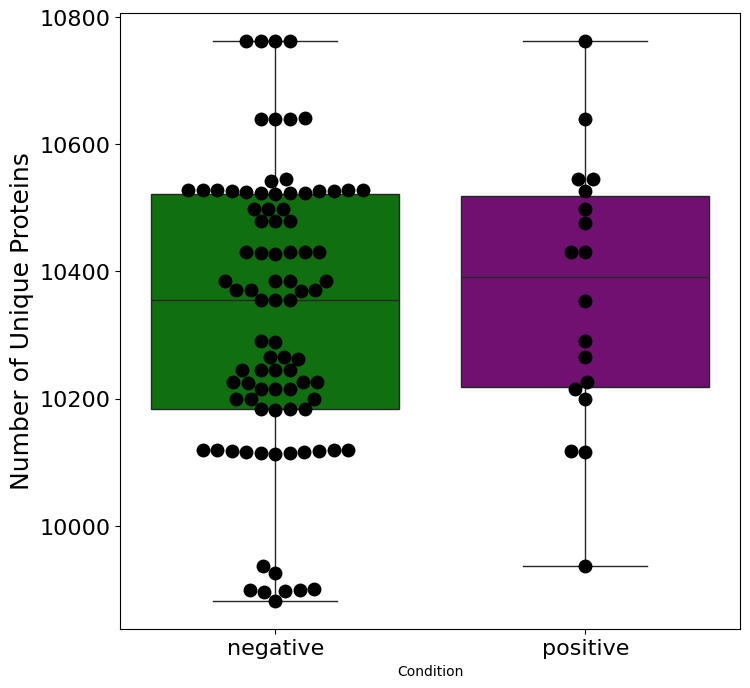

In [ ]:
# For TAN status, using the unfiltered dataset (no proteins removed)

# Extracting patient columns with abundance values
patient_cols = [col for col in unfiltered_tumour.columns if col.endswith(('TAN_negative', 'TAN_positive'))]
protein_abundance = unfiltered_tumour[patient_cols]

# Initialize an empty dictionary to store counts
counts_dict = {}

# Loop through each column in data
for col in protein_abundance:
    # Count non-missing values in this column
    count = protein_abundance[col].count()

    # Extract condition name (excluding patient sample ID)
    condition = col.split('_')[-1]

    # Append the count to the dictionary
    if condition not in counts_dict:
        counts_dict[condition] = [count]
    else:
        counts_dict[condition].append(count)

# Convert the dictionary to a Dataframe
counts_df = pd.DataFrame.from_dict(counts_dict, orient = 'index')
counts_df = counts_df.transpose()

# Melt the dataframe for plotting (convert it to long format)
melted_df = counts_df.melt(var_name = 'Condition', value_name = 'Count')

# Create a colour mapping dictionary based on the Condition
colour_map= {'negative': 'green', 'positive': 'purple'}

# Plotting
plt.figure(figsize = (8, 8))
sns.boxplot(x = 'Condition', y = 'Count', data = melted_df, palette = colour_map)
sns.swarmplot(x = 'Condition', y = 'Count', data = melted_df, color = 'black', s = 10)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Number of Unique Proteins",fontsize=18)
plt.savefig("Proteins_Counts_Total_Cells.eps",format="eps")
plt.show()


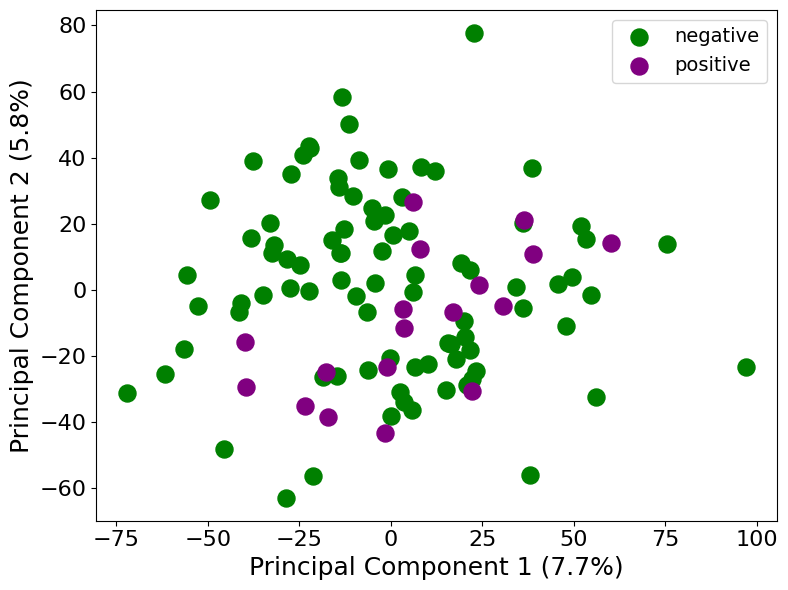

In [ ]:
 # For unfiltered tan status
# potentially scale axis to variance to visualize better

sample_cols = [col for col in unfiltered_tumour.columns if col.endswith(('_negative', '_positive'))]
protein_data = unfiltered_tumour[sample_cols]
protein_data_imputed = protein_data.fillna(0)

scaler = StandardScaler()
protein_data_scaled = scaler.fit_transform(protein_data_imputed.T)
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(protein_data_scaled)

pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

# Prepare unique identifiers for plotting
unique_identifiers = [col.split('_')[-1] for col in sample_cols]
unique_colours = ['green', 'purple']
colour_dict = dict(zip(set(unique_identifiers), unique_colours))

# Assigning colours and markers based on condition
pca_df['identifier'] = unique_identifiers
pca_df['colour'] = [colour_dict[id] for id in unique_identifiers]
pca_df['marker'] = ['s' if 'tumour' in id else 'o' for id in unique_identifiers]

# Calculate the percentage of variance explained by each of the selected components
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Update the axis labels to include the explained variance
plt.figure(figsize=(8, 6))
for identifier, group_df in pca_df.groupby('identifier'):
    plt.scatter(group_df['PC1'], group_df['PC2'], color=colour_dict[identifier],
                label=identifier, marker=group_df['marker'].iloc[0], s=150)


# Formatting labels with explained variance
pc1_label = f"Principal Component 1 ({explained_variance[0]:.1f}%)"
pc2_label = f"Principal Component 2 ({explained_variance[1]:.1f}%)"

plt.xlabel(pc1_label, fontsize=18)
plt.ylabel(pc2_label, fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("PCA_Conditions_with_variance.eps", format="eps")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

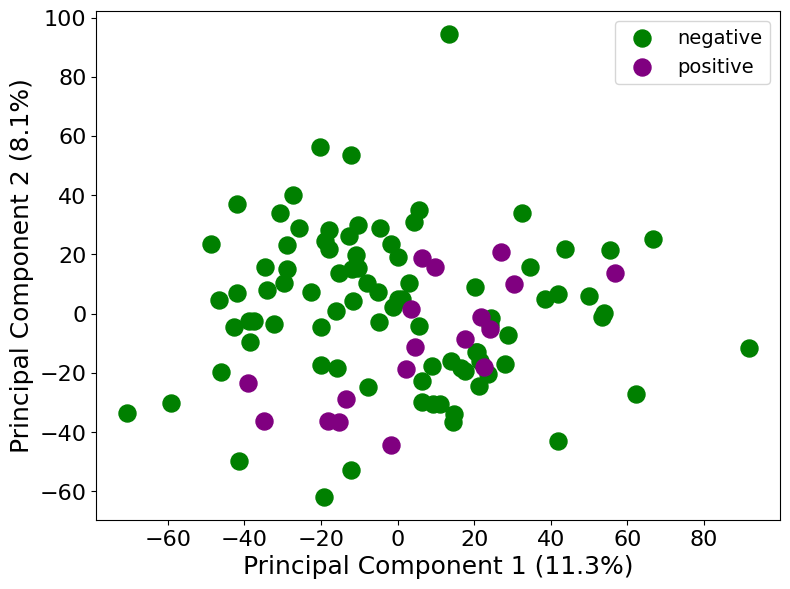

In [ ]:
# For TAN STATUS filtered
# potentially scale axis to variance to visualize better

sample_cols = [col for col in tumour_stats.columns if col.endswith(('_negative', '_positive'))]
protein_data = tumour_stats[sample_cols]
protein_data_imputed = protein_data.fillna(0)

scaler = StandardScaler()
protein_data_scaled = scaler.fit_transform(protein_data_imputed.T)
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(protein_data_scaled)

pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

# Prepare unique identifiers for plotting
unique_identifiers = [col.split('_')[-1] for col in sample_cols]
unique_colours = ['green', 'purple']
colour_dict = dict(zip(set(unique_identifiers), unique_colours))

# Assigning colours and markers based on condition
pca_df['identifier'] = unique_identifiers
pca_df['colour'] = [colour_dict[id] for id in unique_identifiers]
pca_df['marker'] = ['s' if 'tumour' in id else 'o' for id in unique_identifiers]

# Calculate the percentage of variance explained by each of the selected components
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Update the axis labels to include the explained variance
plt.figure(figsize=(8, 6))
for identifier, group_df in pca_df.groupby('identifier'):
    plt.scatter(group_df['PC1'], group_df['PC2'], color=colour_dict[identifier],
                label=identifier, marker=group_df['marker'].iloc[0], s=150)


# Formatting labels with explained variance
pc1_label = f"Principal Component 1 ({explained_variance[0]:.1f}%)"
pc2_label = f"Principal Component 2 ({explained_variance[1]:.1f}%)"

plt.xlabel(pc1_label, fontsize=18)
plt.ylabel(pc2_label, fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("PCA_Conditions_with_variance.eps", format="eps")
plt.show()

In [ ]:
def generate_volcano_plot(dataframe, p_value_col, fold_change_col, labelled_points):
    '''
    Generates a volcano plot with the top 20 points labeled.

    :param dataframe: Dataframe containing the data
    :param p_value_col: Column name for -log10(p-value)
    :param fold_change_col: Column name for log2 fold changes
    :param labelled_points: integer for how many points of interest should be labelled
    '''
    # Extract unique substring for title
    unique_substring = fold_change_col.split(' ')[-1]

    # Calculate the product of absolute Log2 fold change and -Log10 p-value
    dataframe['prod'] = dataframe[fold_change_col].abs() * dataframe[p_value_col]

    # Identify the top proteins
    top_points = dataframe.nlargest(labelled_points, 'prod')

    # Plotting
    plt.figure(figsize=(12, 8))
    significant = dataframe[p_value_col] >= -np.log10(0.05)
    upregulated = dataframe[fold_change_col] >= 1
    downregulated = dataframe[fold_change_col] <= -1

    # Colour points based on significance and fold change
    plt.scatter(dataframe[fold_change_col], dataframe[p_value_col], alpha=0.25, color='gray',s=20)
    upregulated_points = dataframe[fold_change_col][significant & upregulated]
    downregulated_points = dataframe[fold_change_col][significant & downregulated]
    plt.scatter(upregulated_points, dataframe[p_value_col][significant & upregulated], color='purple')
    plt.scatter(downregulated_points, dataframe[p_value_col][significant & downregulated], color='green')

    # Label top proteins and use adjustText
    texts = []
    for _, row in top_points.iterrows():
        texts.append(plt.text(row[fold_change_col], row[p_value_col], row['Gene_Name']))

    adjust_text(texts,arrowprops=dict(arrowstyle='-', color='black'))

    # Display counts
    plt.text(0.95, 0.95, f'Upregulated: {len(upregulated_points)}',
             horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, color='purple')
    plt.text(0.05, 0.95, f'Downregulated: {len(downregulated_points)}',
             horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes, color='green')

    plt.xlabel('Log2 Fold Change',fontsize=18)
    plt.ylabel('-log10(p-value)',fontsize=18)
    plt.axhline(y=-np.log10(0.05), color='r', linestyle='--')  # Threshold line for p-value
    plt.axvline(x=1, color='gray', linestyle='--')  # Threshold line for fold change
    plt.axvline(x=-1, color='gray', linestyle='--')  # Threshold line for fold change
    plt.xticks(fontsize=16)
    # plt.ylim([-5, 10])
    plt.yticks(fontsize=16)
    plt.show()
    return significant

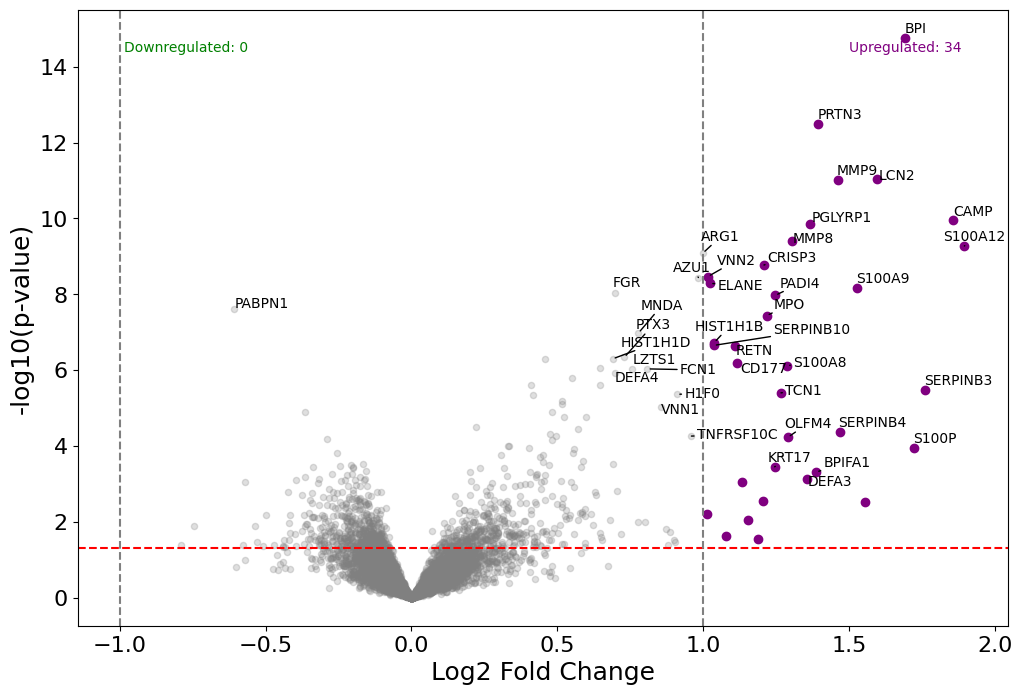

In [ ]:
comparison_id="+_-"
significant = generate_volcano_plot(
    tumour_stats,
    f'-Log Student\'s T-test p-value {comparison_id}',
    f'Student\'s T-test Difference {comparison_id}',
    40
)

In [ ]:
# Extract the gene names for the significant proteins identified in the generate volcano plot function - carry these forward in feature selection?

import numpy as np
significant_genes = tumour_stats[tumour_stats['-Log Student\'s T-test p-value +_-'] >= -np.log10(0.05)]['Gene_Name']
print(significant_genes)

3           FGR
4           CFH
12          BAD
22        CFLAR
26         ARF5
         ...   
7901      SRXN1
7907    POM121C
7918      CCL18
7925      CCL14
7937     DHRS11
Name: Gene_Name, Length: 925, dtype: object


In [ ]:
# TAN status two sample t test results from perseus - This is after NaN values have been filtered out (protein present in every single patient - can change this filter)
feature_df = pd.read_excel(r'/content/gdrive/My Drive/Colab Notebooks/LUAD Proteomics/featureselectiontanstatus.xlsx')

In [ ]:

# Extract only the first row and genes
selected_rows = feature_df.iloc[[0]].append(feature_df[feature_df['Gene_Name'].isin(significant_genes)])

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
selected_rows

In [ ]:
# prompt: export this dataframe as an excel sheet

selected_rows.to_excel("/content/gdrive/My Drive/Colab Notebooks/LUAD Proteomics/significant_genes_tan_status.xlsx", index=False)


## Gene Set Enrichment Analysis Using GSEApy

In [ ]:
gsea_tanstatus = tumour_stats.rename(columns={"Gene_Name":"Gene"})
column_name = f'-Log Student\'s T-test p-value {comparison_id}'
gsea_tanstats = gsea_tanstatus.dropna(subset=[column_name])
gsea_tanstatus

In [ ]:
gsea_tanstatus["Rank"]=gsea_tanstatus[f"-Log Student\'s T-test p-value {comparison_id}"]*gsea_tanstatus[f"Student\'s T-test Difference {comparison_id}"]

In [ ]:
print(gsea_tanstatus.Rank)
gsea_tanstatus=gsea_tanstatus.sort_values("Rank",ascending=False).reset_index(drop=True)
gsea_tanstatus.head(5)

In [ ]:
ranking_status=gsea_tanstatus[["Gene","Rank"]]

ranking_status = ranking_status.astype({'Gene': 'str', 'Rank': 'float'})
ranking_status

In [ ]:
x=gp.get_library_name()

# Specify the substring you are looking for
substring = 'GO'

# Filter the list for terms that include the substring
filtered_terms = [term for term in x if substring in term]

# Print the filtered list
print(filtered_terms)

In [ ]:
import matplotlib

### Cellular Component Gene Ontology

In [ ]:
pre_res_cc=gp.prerank(rnk=ranking_status,gene_sets='GO_Cellular_Component_2023', seed=6)

In [ ]:
terms_cc = pre_res_cc.res2d.Term
axs_cc = pre_res_cc.plot(terms_cc[:8], show_ranking=False, legend_kws={'loc': (1.05, -0.5)}, )

In [ ]:
from gseapy import dotplot
# to save your figure, make sure that ``ofname`` is not None
ax_cc = dotplot(pre_res_cc.res2d,
             column="FDR q-val",
             title='GO:Cellular Component',
             cmap=plt.cm.PiYG_r,
             size=5,
             figsize=(4,6), cutoff=1)

In [ ]:
#Cellular component Barplot
from gseapy import barplot
ax_cc_1 = barplot(pre_res_cc.res2d,title='GO:Cellular Component',column="FDR q-val",cmap = plt.cm.PiYG_r, figsize=(4, 6), color='darkred')


In [ ]:
out_cc=[]

for term in pre_res_cc.results:
  p = pre_res_cc.results[term]['pval']
  fdr = pre_res_cc.results[term]['fdr']
  nes = pre_res_cc.results[term]['nes']
  es = pre_res_cc.results[term]['es']
  gene = pre_res_cc.results[term]['lead_genes']
  out_cc.append([term, p, fdr, nes, es, gene])


out_df_cc=pd.DataFrame(out_cc,columns=["Term","p_value","fdr","nes","es","gene"]).sort_values("fdr").reset_index(drop=True)
out_df_cc.head(20)

In [ ]:
# Plot the GSEA figure for specific terms

from gseapy.plot import gseaplot
import matplotlib.pyplot as plt

# plt.rcParams['font.size'] = 12

term_to_plot_cc = out_df_cc['Term'][0]

gseaplot(rank_metric=pre_res_cc.ranking, term =term_to_plot_cc, **pre_res_cc.results[term_to_plot_cc])

# plt.savefig('GSEA_plot.png', dpi=300, facecolor='white', bbox_inches='tight')

In [ ]:
# Plot the GSEA figures for the top 10 terms

for term in out_df_cc['Term'][0:10]:
  gp.plot.gseaplot(rank_metric=pre_res_cc.ranking, term = term, **pre_res_cc.results[term])

### Biological Processes Gene Ontology

In [ ]:
pre_res_bp=gp.prerank(rnk=ranking_status,gene_sets='GO_Biological_Process_2023', seed=6)

In [ ]:
terms_bp = pre_res_bp.res2d.Term
axs_bp = pre_res_bp.plot(terms_bp[:8], show_ranking=False, legend_kws={'loc': (1.05, -0.5)}, )

In [ ]:
from gseapy import dotplot
# to save your figure, make sure that ``ofname`` is not None
ax_bp = dotplot(pre_res_bp.res2d,
             column="FDR q-val",
             title='GO:Biological Process',
             cmap=plt.cm.PiYG_r,
             size=5,
             figsize=(4,6), cutoff=1)

In [ ]:
#Biological Processes Barplot
from gseapy import barplot
ax_bp1 = barplot(pre_res_bp.res2d,title='GO:Biological Component',column="FDR q-val",cmap = plt.cm.PiYG_r, figsize=(4, 6), color='darkred')

In [ ]:
out_bp=[]

for term in pre_res_bp.results:
  p = pre_res_bp.results[term]['pval']
  fdr = pre_res_bp.results[term]['fdr']
  nes = pre_res_bp.results[term]['nes']
  es = pre_res_bp.results[term]['es']
  gene = pre_res_bp.results[term]['lead_genes']
  out_bp.append([term, p, fdr, nes, es, gene])


out_df_bp=pd.DataFrame(out_bp,columns=["Term","p_value","fdr","nes","es","gene"]).sort_values("fdr").reset_index(drop=True)
out_df_bp.head(20)

In [ ]:
# Plot the GSEA figure for specific terms

from gseapy.plot import gseaplot
import matplotlib.pyplot as plt

# plt.rcParams['font.size'] = 12

term_to_plot_bp = out_df_bp['Term'][0]

gseaplot(rank_metric=pre_res_bp.ranking, term =term_to_plot_bp, **pre_res_bp.results[term_to_plot_bp])

# plt.savefig('GSEA_plot.png', dpi=300, facecolor='white', bbox_inches='tight')

In [ ]:
# Plot the GSEA figures for the top 10 terms

for term in out_df_bp['Term'][0:10]:
  gp.plot.gseaplot(rank_metric=pre_res_bp.ranking, term = term, **pre_res_bp.results[term])

### Molecular Function Gene Ontology

In [ ]:
pre_res_mf=gp.prerank(rnk=ranking_status,gene_sets='GO_Molecular_Function_2023', seed=6)

In [ ]:
terms_mf = pre_res_mf.res2d.Term
axs_mf = pre_res_mf.plot(terms_mf[:8], show_ranking=False, legend_kws={'loc': (1.05, -0.5)}, )

In [ ]:
from gseapy import dotplot
# to save your figure, make sure that ``ofname`` is not None
ax_mf = dotplot(pre_res_mf.res2d,
             column="FDR q-val",
             title='GO:Molecular Function',
             cmap=plt.cm.PiYG_r,
             size=5,
             figsize=(4,6), cutoff=1)

In [ ]:
#Molecular Function Barplot
from gseapy import barplot
ax = barplot(pre_res_mf.res2d,title='GO:Molecular Function',column="FDR q-val",cmap = plt.cm.PiYG_r, figsize=(4, 6), color='darkred', cutoff=0.2)

In [ ]:
out_mf=[]

for term in pre_res_mf.results:
  p = pre_res_mf.results[term]['pval']
  fdr = pre_res_mf.results[term]['fdr']
  nes = pre_res_mf.results[term]['nes']
  es = pre_res_mf.results[term]['es']
  gene = pre_res_mf.results[term]['lead_genes']
  out_mf.append([term, p, fdr, nes, es, gene])


out_df_mf=pd.DataFrame(out_mf,columns=["Term","p_value","fdr","nes","es","gene"]).sort_values("fdr").reset_index(drop=True)
out_df_mf.head(20)

In [ ]:
# Plot the GSEA figure for specific terms

from gseapy.plot import gseaplot
import matplotlib.pyplot as plt

# plt.rcParams['font.size'] = 12

term_to_plot_mf = out_df_mf['Term'][0]

gseaplot(rank_metric=pre_res_mf.ranking, term =term_to_plot_mf, **pre_res_mf.results[term_to_plot_mf])

# plt.savefig('GSEA_plot.png', dpi=300, facecolor='white', bbox_inches='tight')

In [ ]:
for term in out_df_mf['Term'][0:10]:
  gp.plot.gseaplot(rank_metric=pre_res_mf.ranking, term = term, **pre_res_mf.results[term])

## **Function for GSEA**

### Function Design

In [ ]:
# Designing Function(s) to clean up this code!
# function assumes gseapy was imported as gp

def gene_ontology_analysis(df, ontology_category):
    # Perform prerank analysis
    pre_res = gp.prerank(rnk=df, gene_sets=f'GO_{ontology_category}_2023', seed=6)

    # Plot the top 8 terms
    terms_top8 = pre_res.res2d.Term[:8]
    axs = pre_res.plot(terms_top8, show_ranking=False, legend_kws={'loc': (1.05, -0.5)})

    # Dotplot
    ax = gp.dotplot(pre_res.res2d,
                      column="FDR q-val",
                      title=f'GO:{ontology_category}',
                      cmap=plt.cm.viridis_r,
                      size=12,
                      figsize=(4, 6),
                      cutoff=1)

    # Extract results
    out_results = []
    for term in pre_res.results:
        p = pre_res.results[term]['pval']
        fdr = pre_res.results[term]['fdr']
        nes = pre_res.results[term]['nes']
        es = pre_res.results[term]['es']
        gene = pre_res.results[term]['lead_genes']
        out_results.append([term, p, fdr, nes, es, gene])

    # Create DataFrame
    out_df = pd.DataFrame(out_results, columns=["Term", "p_value", "fdr", "nes", "es", "gene"]).sort_values("fdr").reset_index(drop=True)
    out_df["Ontology_Category"] = ontology_category  # Add ontology category column

    # Display top 20 results
    out_df.head(20)

    # Plot GSEAPy plots for top 10 terms
    for term in out_df['Term'][:10]:
        gp.plot.gseaplot(rank_metric=pre_res.ranking, term=term, **pre_res.results[term])

    return out_df


### Cellular Componenets

In [ ]:
cc_results = gene_ontology_analysis(ranking_status, 'Cellular_Component')

In [ ]:
cc_results

### Biological Process

In [ ]:
gene_ontology_analysis(ranking_status, 'Biological_Process')

### Molecular Function

In [ ]:
gene_ontology_analysis(ranking_status, 'Molecular_Function')

# Reactome

In [ ]:
x=gp.get_library_name()

# Specify the substring you are looking for
substring = 'Reactome'

# Filter the list for terms that include the substring
filtered_terms = [term for term in x if substring in term]

# Print the filtered list
print(filtered_terms)

In [ ]:
pre_res = gp.prerank(rnk=ranking_status, gene_sets=f'Reactome_2022', seed=6)

# Plot the top 8 terms
terms_top8 = pre_res.res2d.Term[:8]
axs = pre_res.plot(terms_top8, show_ranking=False, legend_kws={'loc': (1.05, -0.5)})

# Dotplot
ax = gp.dotplot(pre_res.res2d,
                      column="FDR q-val",
                      title=f'Reactome',
                      cmap=plt.cm.viridis_r,
                      size=12,
                      figsize=(4, 6),
                      cutoff=1)
# Extract results
out_results = []
for term in pre_res.results:
        p = pre_res.results[term]['pval']
        fdr = pre_res.results[term]['fdr']
        nes = pre_res.results[term]['nes']
        es = pre_res.results[term]['es']
        gene = pre_res.results[term]['lead_genes']
        out_results.append([term, p, fdr, nes, es, gene])

# Create DataFrame
out_df = pd.DataFrame(out_results, columns=["Term", "p_value", "fdr", "nes", "es", "gene"]).sort_values("fdr").reset_index(drop=True)
out_df["Reactome"] = 'reactome'  # Add reactome category column

# Plot GSEAPy plots for top 10 terms
for term in out_df['Term'][:10]:
        gp.plot.gseaplot(rank_metric=pre_res.ranking, term=term, **pre_res.results[term])



In [ ]:
# Display top 20 results
out_df.head(20)

In [ ]:
# prompt: Using dataframe out_df: Extract a new dataframe containing only the rows with FDR less than 0.01

out_df_fdr = out_df[out_df['fdr'] < 0.01]


In [ ]:
out_df_fdr

In [ ]:
#Reactome Barplot
ax = barplot(pre_res.res2d,title='Reactome', column="FDR q-val", figsize=(4, 5), color='darkred', cmap = plt.cm.viridis_r)



# KEGG Human


In [ ]:
x=gp.get_library_name()

# Specify the substring you are looking for
substring = 'KEGG'

# Filter the list for terms that include the substring
filtered_terms = [term for term in x if substring in term]

# Print the filtered list
print(filtered_terms)

In [ ]:
pre_res = gp.prerank(rnk=ranking_status, gene_sets=f'KEGG_2021_Human', seed=6)

# Plot the top 8 terms
terms_top8 = pre_res.res2d.Term[:8]
axs = pre_res.plot(terms_top8, show_ranking=False, legend_kws={'loc': (1.05, -0.5)})

# Dotplot
ax = gp.dotplot(pre_res.res2d,
                      column="FDR q-val",
                      title=f'KEGG_2021_Human',
                      cmap=plt.cm.viridis_r,
                      size=12,
                      figsize=(4, 6),
                      cutoff=1)
# Extract results
out_results = []
for term in pre_res.results:
        p = pre_res.results[term]['pval']
        fdr = pre_res.results[term]['fdr']
        nes = pre_res.results[term]['nes']
        es = pre_res.results[term]['es']
        gene = pre_res.results[term]['lead_genes']
        out_results.append([term, p, fdr, nes, es, gene])

# Create DataFrame
out_df = pd.DataFrame(out_results, columns=["Term", "p_value", "fdr", "nes", "es", "gene"]).sort_values("fdr").reset_index(drop=True)
out_df["KEGG_2021_Human"] = 'KEGG'  # Add reactome category column

# Plot GSEAPy plots for top 10 terms
for term in out_df['Term'][:10]:
        gp.plot.gseaplot(rank_metric=pre_res.ranking, term=term, **pre_res.results[term])


In [ ]:
out_df

In [ ]:
# prompt: Using dataframe out_df: Using this, create a barplot that has nes on the x axis, and significant terms (fdr<0.05) on the y axis and colour code the bars relating to their fdr  value

import altair as alt

df_sig = out_df[out_df['fdr'] < 0.05]
chart = alt.Chart(df_sig).mark_bar().encode(
    x = alt.X('nes', title='NES'),
    y = alt.Y('Term', title='Significant terms (FDR < 0.05)', sort=alt.EncodingSortField(field="nes", order='descending')),
    color = alt.Color('fdr:Q', title='FDR', scale=alt.Scale(scheme='viridis'))
)
chart


In [ ]:
#KEGG Human Barplot
ax = barplot(pre_res.res2d,title = f'KEGG_2021_Human', column="FDR q-val", figsize=(4, 5), color='darkred', cmap = plt.cm.viridis_r)